### Install dependencies

In [1]:
!pip install keras_tqdm
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
import random
import math
import csv 

import keras
from keras_tqdm import TQDMNotebookCallback
from keras import backend as K
from keras import losses
from keras.models import load_model
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt 
from matplotlib import patches as mpatches

from sklearn import preprocessing
from sklearn import model_selection

2022-05-19 12:28:15.781957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 12:28:15.781981: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Generate cartesian values given robot arm lengths and angle ranges (degrees)

In [5]:
#init values
link_arm_1 = 86.
link_arm_2 = 55.

#define functions
def cart_coord(thet1,thet2):
    """
    Given angles (in radians) give cartesian coordinates of the end-effector
    """
    X_coord = link_arm_1 * np.cos(thet1) + link_arm_2 * np.cos(thet2 + thet1)
    Y_coord = link_arm_1 * np.sin(thet1) + link_arm_2 * np.sin(thet2 + thet1)
    return X_coord, Y_coord

def x_cart_coord(thet1,thet2):
    """
    Given angles (in radians) give cartesian coordinates of the end-effector
    """
    X_coord = link_arm_1 * np.cos(thet1) + link_arm_2 * np.cos(thet2 + thet1)
    Y_coord = link_arm_1 * np.sin(thet1) + link_arm_2 * np.sin(thet2 + thet1)
    return X_coord

def y_cart_coord(thet1,thet2):
    """
    Given angles (in radians) give cartesian coordinates of the end-effector
    """
    X_coord = link_arm_1 * np.cos(thet1) + link_arm_2 * np.cos(thet2 + thet1)
    Y_coord = link_arm_1 * np.sin(thet1) + link_arm_2 * np.sin(thet2 + thet1)
    return Y_coord


Q1 = []
Q2 = []
posX = []
posY = []
samples = 5000


file = open ("traing_data_12052022.csv","w")                             # Data Set Creation
for i in range (0,samples):
    
    q1 = round(random.uniform(math.radians(-45.), math.radians(100.)),2)
    q2 = round(random.uniform(math.radians(-45.), math.radians(180)),2)


    Q1.append(q1)
    file.write(str(q1))
    file.write(",")

    Q2.append(q2)
    file.write(str(q2))
    file.write(",")  
              
    X = x_cart_coord(q1,q2)
    posX.append(X)
    file.write(str(round(X, 2)))
    file.write(",")

    Y =y_cart_coord(q1,q2)
    posY.append(Y)
    file.write(str(round(Y, 2)))
              
    file.write("\n")

file.close()

(0.0, 150.0)

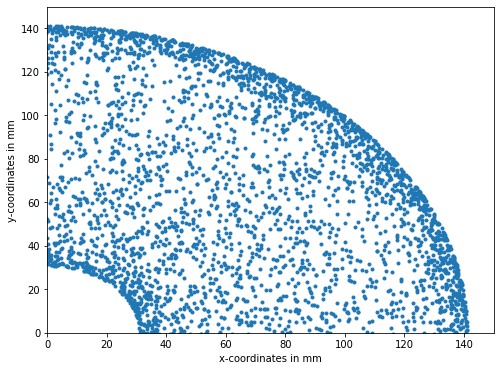

In [6]:
font_size_defined = 'x-large'
fig = plt.figure(1,figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('x-coordinates in mm')
ax1.set_ylabel('y-coordinates in mm')
ax1.scatter(posX,posY,marker='.')
ax1.set_xlim(0,150)
ax1.set_ylim(0,150)

#### Remove duplicate points

In [8]:
data = np.c_[Q1,Q2,posX,posY] 

tol = 0.8 # minimum spacing between cartesian points in mm
indices_to_ignore = np.empty((0,1))

for i in range(0,len(data)):                         # Removing duplicated end effeector positions
    for j in range(0,len(data)):
        if i != j:
            #print(i,j,'checking..')
            # if (dataMat[j,2] == check1 and dataMat[j,3] == check2): # old code for testing whether two entries were identical
            if np.sqrt((data[i,2] - data[j,2])**2 + (data[i,3] - data[j,3])**2) < tol: # interpoint spacing 
                #print("excluded columns")
                #print(i)#,j,data[j,2],data[j,3])
                indices_to_ignore = np.append(indices_to_ignore, i)



In [9]:
dataMat = np.empty((0,4))
for row in range(len(data)):
    if row not in indices_to_ignore:
        dataMat = np.append(dataMat, [data[row]], axis=0)

(0.0, 150.0)

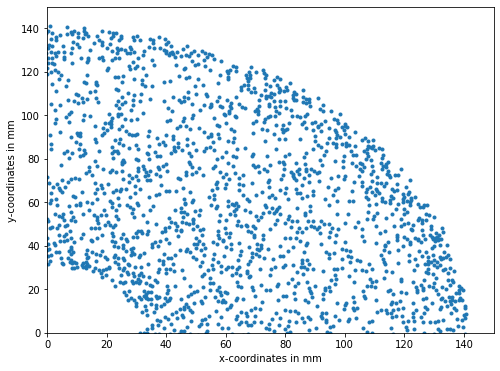

In [10]:
font_size_defined = 'x-large'
fig = plt.figure(1,figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('x-coordinates in mm')
ax1.set_ylabel('y-coordinates in mm')
ax1.scatter(dataMat[:,2],dataMat[:,3],marker='.')
ax1.set_xlim(0,150)
ax1.set_ylim(0,150)

#### Train neural network

In [11]:
data_processed = dataMat
np.save('dataMat_12052022',data_processed)

In [4]:
check_data = np.load('dataMat_12052022.npy')

In [5]:
check_data

array([[  0.48      ,   1.49      ,  54.90390192,  90.38840344],
       [  0.45      ,   1.9       ,  38.78923158,  76.53807034],
       [  0.94      ,   1.69      ,   2.76364544,  96.37616001],
       ...,
       [  0.41      ,   1.05      ,  84.95372865,  88.94316219],
       [ -0.61      ,   1.49      , 105.53304247,  -6.87596323],
       [  0.24      ,  -0.59      , 135.20056504,   1.58304646]])

In [12]:
#split data into training and final test set
input_data = data_processed[:,2:]
label_data = data_processed[:,:2]
input_train, input_test, label, label_test = model_selection.train_test_split(input_data, label_data, test_size=0.15)

#scale
i_scaler = preprocessing.MinMaxScaler(feature_range=(-1.,1.)) #this range is for tanh
l_scaler = preprocessing.MinMaxScaler(feature_range=(-1.,1.))
i_train = i_scaler.fit_transform(input_train)
l_train = l_scaler.fit_transform(label)
i_test  = i_scaler.transform(input_test)
l_test  = l_scaler.transform(label_test)

no_ep = 200 #number of epochs

#def custom_loss(label_True,label_Pred):
#    return(K.sum((label_True-label_Pred)**2)/len(i_train))

model1 = keras.Sequential()
model1.add(keras.layers.Dense(2,activation='linear'))
model1.add(keras.layers.Dense(100, use_bias=True, activation='tanh'))
model1.add(keras.layers.Dense(100, use_bias=True, activation='tanh')) # not really necessary but speeds up convergence
model1.add(keras.layers.Dense(2, use_bias=True, activation='linear'))

#model1.compile(optimizer = 'adam', loss=custom_loss, metrics=['accuracy'])
model1.compile(optimizer = 'adam', loss=losses.mean_squared_error, metrics=['accuracy'])
#model1.compile(optimizer = 'adam', loss=losses.logcosh, metrics=['accuracy'])

results = model1.fit(i_train,l_train, validation_split=0.15, epochs=no_ep, verbose=0)#, callbacks=[TQDMNotebookCallback()])

2022-05-18 23:53:33.297688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 23:53:33.297723: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 23:53:33.297760: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-05-18 23:53:33.298076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Save / load model parameters

In [15]:
#save model as file -  function "load_model" from "keras.models"
#model1.save('19052022_s100_model1.h5')

#from keras.models import load_model
model1 = load_model('19052022_s100_model1.h5')
# need to follow these steps: https://colab.research.google.com/notebooks/snippets/drive.ipynb

#### Visualise model results / sanity check

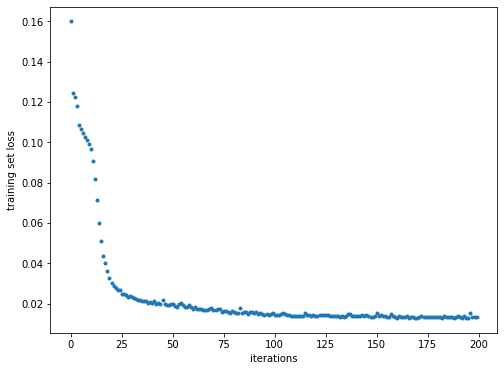

In [16]:
#plot cost on training set
font_size_defined = 'x-large'
fig = plt.figure(1,figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('iterations')
ax1.set_ylabel('training set loss')
ax1.scatter(np.array(range(no_ep)),results.history['loss'],marker='.')

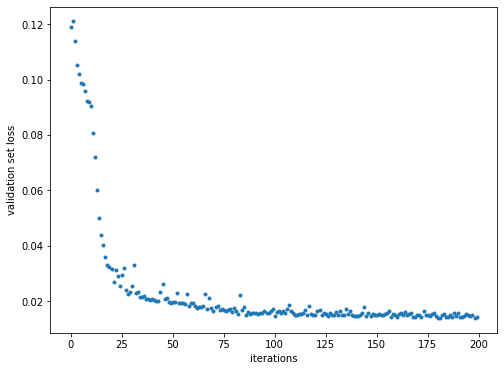

In [17]:
#plot cost on validation set
font_size_defined = 'x-large'
fig2 = plt.figure(1,figsize=(8,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.set_xlabel('iterations')
ax2.set_ylabel('validation set loss')
ax2.scatter(np.array(range(no_ep)),results.history['val_loss'],marker='.')

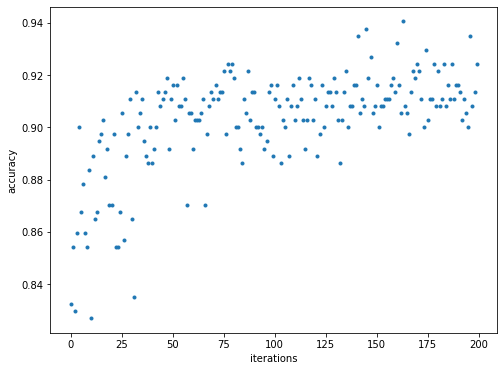

In [18]:
#plot accuracy
font_size_defined = 'x-large'
fig3 = plt.figure(1,figsize=(8,6))
ax3 = fig3.add_subplot(1,1,1)
ax3.set_xlabel('iterations')
ax3.set_ylabel('accuracy')
ax3.scatter(np.array(range(no_ep)),results.history['val_accuracy'],marker='.')

In [19]:
data_input = i_scaler.transform(data[:,2:])
test_prediction = model1.predict(data_input)
real_prediction = l_scaler.inverse_transform(test_prediction)

157/157 [==============================] - 0s 908us/step


#### Plot predicted vs actual angle (performance of model)

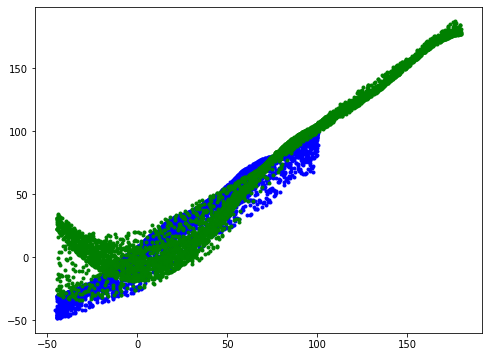

In [20]:
font_size_defined = 'x-large'
fig5 = plt.figure(1,figsize=(8,6))
ax5 = fig5.add_subplot(1,1,1)
#ax5.set_xlabel('true angles')
#ax5.set_ylabel('predicted angles')
ax5.scatter(np.degrees(data[:,0]),np.degrees(real_prediction[:,0]),c='b',marker='.')
ax5.scatter(np.degrees(data[:,1]),np.degrees(real_prediction[:,1]),c='g',marker='.')
#ax5.scatter(np.degrees(data[:,0]),np.degrees(theta_pred),color='g',marker='.')#,label='PRED')

### Convert cartesian coordinates to polar

Do this here if 

In [ ]:
frac_coordinates = {'frac1': np.array([[40,40]]), 'frac2': np.array([[60,40]]), 'frac3': np.array([[79,40]]), \
                    'frac4': np.array([[96,40]]), 'frac5': np.array([[110,40]]), 'frac6': np.array([[127,40]]), \
                    'frac7': np.array([[40,57]]), 'frac8': np.array([[60,57]]), 'frac9': np.array([[79,57]]), \
                    'frac10': np.array([[96,57]]), 'frac11': np.array([[110,57]]), 'frac12': np.array([[127,57]])}

In [ ]:
frac_coords_polar = frac_coordinates.copy()

for key in frac_coordinates:
    frac_coords_polar[key] = np.degrees(model1.predict(frac_coordinates[key]))